# Hands on timeseries analysis
### part9: Introducing ARIMA 2

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.08.26 </div> 
<div style="text-align: right"> Last update: 2020.08.26</div> 

파이썬 statsmodels 라이브러리의 arima_model을 사용하여 시계열 예측모델을 학습하고, 성능평가 하는 방법에 대하여 살펴본다.  
ARIMA 모델의 하이퍼파라미터(p, q, d)를 설정하는 방법에 대하여 알아본다.
- 참고자료  
    - [Pandas로 하는 시계열 데이터분석](https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=152#sec2)
    - [Time series analysis in Python](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)
    - [A comprehensive beginner’s guide to create a Time Series Forecast](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)  
    - [How to grid search ARIMA model hyperparameters with python](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)

### 1. Machine learning에서의 hyperparameter

하이퍼파라미터란 machine learning 모델을 학습시킬 때 학습성능이나 예측성능 효과를 높이기 위해 설계자가 수동으로 설정해줘야 하는 변수들이다. 뉴럴넷을 예로 들자면 learning rate, cost function, regularization parmeter 등이 있다.

ARIMA(p, d, q) 모델의 계산식을 살펴보자.  
- AR(Auto-Regressive) : $AR = \phi_{0} + \phi_{1} \cdot y_{t-1} + ... + \phi_{p} \cdot y_{t-p} $
- MA(Moving Average) : $MA = \theta_{0} + \theta_{1} \cdot \epsilon_{t-1} + ... + \theta_{q} \cdot \epsilon_{t-q} $
- I(Integrated) : $I = y_t - y_{t-d} $
$$ \hat{y}_{t} = constant + AR + MA$$

예를 들어 d = 1이면

- AR(Auto-Regressive) : $AR = \phi_{0} + \phi_{1} \cdot \Delta y_{t-1} + ... + \phi_{p} \cdot \Delta y_{t-p} $
- MA(Moving Average) : $MA = \theta_{0} + \theta_{1} \cdot \epsilon_{t-1} + ... + \theta_{q} \cdot \epsilon_{t-q} $  
$$ \Delta \hat{y}_{t} = constant + AR + MA$$  
$$ \Delta {y}_{t} = y_t - y_{t-1} $$

여기서 모델을 학습하기전 설계자가 설정해야할 부분은 p, d, q 값이다.  
$\phi$, $\theta$ 등은 학습을 통해 구해지는 값이다.

### 2. Manual setting  
먼저 매뉴얼로 p, d, q를 찾아 설정하고 모델을 학습, 성능을 평가해본다.

#### 2.1 데이터 준비

`airline passengers.csv` 데이터셋을 사용한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_rows', 500)

from sklearn.metrics import mean_squared_error

In [2]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=['Month'])

In [3]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


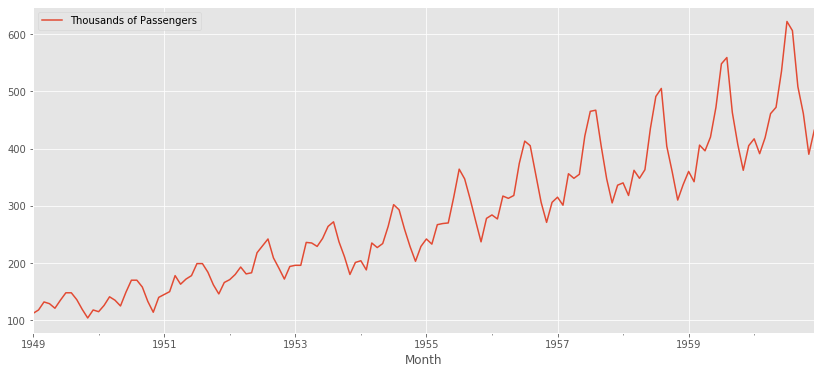

In [4]:
df.plot(figsize = (14, 6))

데이터셋 나누기
- 1960년을 기준으로 학습, 시험 데이터로 구분한다.

In [5]:
train = df[:'1960']
test = df['1960':]

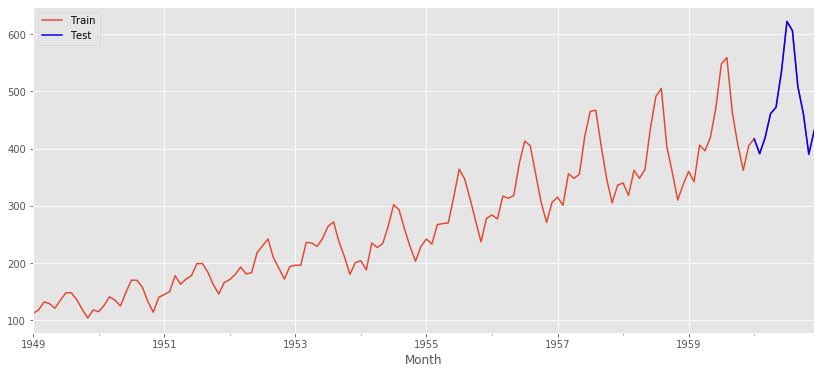

In [6]:
fig, ax = plt.subplots(figsize = (14, 6))
train['Thousands of Passengers'].plot(ax = ax, label = 'Train')
test['Thousands of Passengers'].plot(ax = ax, color = 'b', label = 'Test')
plt.legend()

In [7]:
print('Lenth of Train dataset : {}'.format(len(train)))
print('Lenth of Test dataset : {}'.format(len(test)))

Lenth of Train dataset : 144
Lenth of Test dataset : 12


#### 2.2 파라미터 설정 : ARIMA의 p, d, q 값 찾기  
8장에서 설명한 방법을 통해 p, d, q 값을 찾는다.

편의를 위해 d=1로 설정하고 p, q 값을 찾는다.

시각화를 통해 p, q 찾기

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series): #y가 pd.Series에 적합한 인자인지 확인, 
                                     # ex) isinstance(1.2, int) => False가 리턴
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        dftest = adfuller(y, autolag='AIC')
        if dftest[1] <= 0.05:
            result = 'Stationary'
        else:
            result = 'Non-Stationary'
        ts_ax.set_title('Time Series Analysis Plots\n {0:}: p-value {1:.5f}'.format(result, dftest[1]))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()

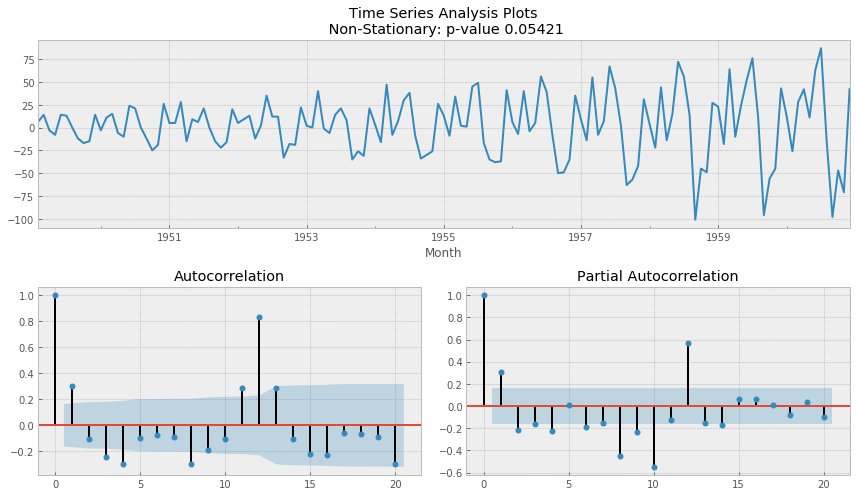

In [10]:
tsplot(train.diff()['Thousands of Passengers'].dropna(), lags = 20)

- ACF, PACF 차트의 하늘색 영역은 신뢰구간을 표시한다. p, q를 결정하는데 사용할 수가 있다.  
- p = 2로 설정한다. PACF에서 lag가 2일 때 최초로 PACF의 상단 신뢰구간을 통과하므로  
- q = 2로 설정한다. ACF에서  lag가 2일 때 최초로 PACF의 상단 신뢰구간을 통과하므로

- (p, d, q) = (2, 1, 2)로 설정한다.

#### 2.3 모델 학습하기

In [11]:
from statsmodels.tsa.arima_model import ARIMA

In [12]:
order = (2, 1, 2)
model = ARIMA(train, order=order)

In [13]:
model_fit = model.fit()

In [14]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                 
=====================================================================================
Dep. Variable:     D.Thousands of Passengers   No. Observations:                  143
Model:                        ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                              css-mle   S.D. of innovations             24.714
Date:                       Thu, 27 Aug 2020   AIC                           1344.043
Time:                               15:08:05   BIC                           1361.820
Sample:                           02-01-1949   HQIC                          1351.267
                                - 12-01-1960                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.5313      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Thousands of Passengers     1.6477      0.033     49.933      0.000       1.583       1.712
ar.L2.D.Thousands of Passengers    -0.9094      0.033    -27.880      0.000      -0.973      -0.845
ma.L1.D.Thousands of Passengers    -1.9098      0.065    -29.536      0.000      -2.037      -1.783
ma.L2.D.Thousands of Passengers     0.9997      0.067     14.819      0.000       0.867       1.132
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9059           -0.5281j            1.0486           -0.0840
AR.2            0.9059           +0.5281j            1.0486            0.0840
MA.1            0.9552           -0.2964j            1.0002           -0.0479
MA.2            0.9552           +0.2964j            1.0002            0.0479
-----------------------------------------------------------------------------
"""

Residual 값 살펴보기 : 학습된 모델이 예측한 값과 실제 데이터(train) 간 오차 살펴보기

In [15]:
model_fit.resid

Month
1949-02-01     3.468657
1949-03-01    10.648802
1949-04-01    -8.221928
1949-05-01    -8.789677
1949-06-01    15.830706
1949-07-01    11.237173
1949-08-01    -1.739755
1949-09-01   -11.367913
1949-10-01   -15.799078
1949-11-01   -17.077374
1949-12-01     5.375763
1950-01-01   -16.477313
1950-02-01    -6.059718
1950-03-01    -2.955330
1950-04-01   -21.330596
1950-05-01   -22.712818
1950-06-01    12.455628
1950-07-01    14.143905
1950-08-01     1.058257
1950-09-01    -4.272622
1950-10-01   -14.634309
1950-11-01   -12.287219
1950-12-01    24.774327
1951-01-01     1.082954
1951-02-01    -1.204284
1951-03-01    20.427883
1951-04-01   -18.577844
1951-05-01     5.389054
1951-06-01     4.041380
1951-07-01    21.082457
1951-08-01     5.416235
1951-09-01    -6.276200
1951-10-01   -14.690294
1951-11-01   -15.424369
1951-12-01    10.921915
1952-01-01    -8.256391
1952-02-01    -7.408583
1952-03-01    -3.893864
1952-04-01   -26.119344
1952-05-01   -11.998848
1952-06-01    22.571688
1952-07-01

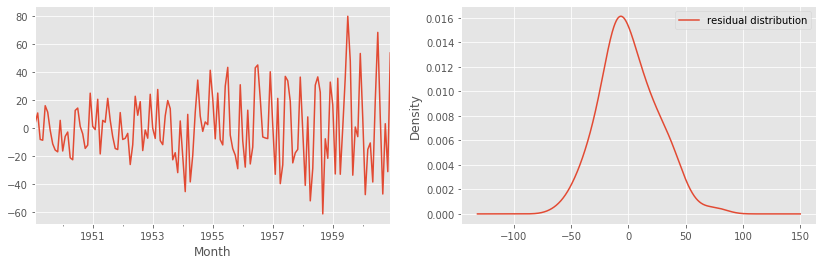

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4))
model_fit.resid.plot(ax = axes[0], label = 'residuals')
model_fit.resid.plot(kind = 'kde', ax = axes[1], label = 'residual distribution')
plt.legend()

In [17]:
model_fit.resid.describe()

count    143.000000
mean       0.370797
std       25.142875
min      -61.347628
25%      -15.611724
50%       -2.313149
75%       17.612887
max       79.631127
dtype: float64

- mean 값이 0이 아니다. : 예측 값에 바이어스가 약간 있음을 의미한다.

#### 2.4 예측하기

In [18]:
test['Forecasts'] = model_fit.forecast(steps = len(test))[0]
#test['Forecasts'] = model.predict(start=test.min(), end=test.max(), dynamic)
# predict함수는 fitted values 다시말해 delta y 값을 예측한다.
# forecast 함수를 사용해야 y 값을 에측한다.
# forecast 함수는 예측값, 표준편차, 신뢰구간을 리턴한다. 따라서 [0]번 인덱스를 취해야함
# 참고자료 
# - https://stackoverflow.com/questions/45596492/statsmodels-arima-different-results-using-predict-and-forecast
# - https://stackoverflow.com/questions/50867221/arima-predict-doesnt-forecast-but-works-for-hindcasting
# - https://machinelearningmastery.com/make-sample-forecasts-arima-python/
# - https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html
# - https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.predict.html

결과 시각화

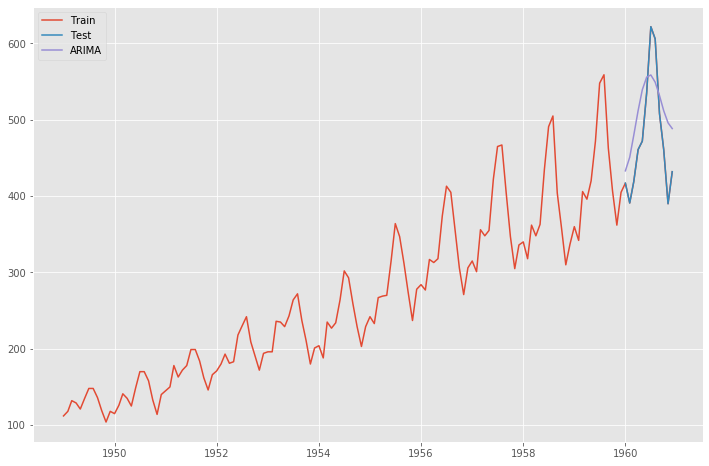

In [19]:
plt.figure(figsize=(12,8))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(test['Forecasts'], label='ARIMA')
plt.legend()

In [20]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'],test['Forecasts']))

In [21]:
rmse

57.673158620848874

### 3. 하이퍼파라미터 튜닝 : Grid search

시험할 p, d, q의 범위를 지정하고 다양한 선택사항에 대하여 성능을 비교한다.

#### 3.1 평가용 함수 만들기

evaluation 함수 만들기

In [22]:
def evaluate_arima_model(train, test, order):
    
    # make predictions
    model = ARIMA(train, order = order)
    model_fit = model.fit(disp = 0)
    forecasts = model_fit.forecast(steps = len(test))[0]
    
    error = np.sqrt(mean_squared_error(test.values,forecasts))
    return error

In [23]:
# 시험해보기
evaluate_arima_model(train['Thousands of Passengers'], test['Thousands of Passengers'], (2, 1, 2))

57.673158620848874

각 모델의 성능을 평가하는 함수 만들기

In [24]:
from tqdm import tqdm_notebook

In [25]:
def evaluate_models(train, test, orders):
    best_score, best_order = float("inf"), None
    for order in orders:
        try:
            rmse = evaluate_arima_model(train, test, order)
            if rmse < best_score:
                best_score, best_order = rmse, order
            print('ARIMA{0} RMSE={1}'.format(order, rmse))
        except:
            continue
    
    print('\n Best ARIMA{0} RMSE={1}'.format(best_order, best_score))

#### 3.3 grid search 범위 지정하기

In [26]:
import itertools

In [27]:
p = range(0,5)
d = range(1,3)
q = range(0,5)

pdq = list(itertools.product(p, d, q))

#### 3.4 최적의 파라미터 찾기

In [28]:
evaluate_models(train['Thousands of Passengers'], test['Thousands of Passengers'],
                orders= pdq)

ARIMA(0, 1, 1) RMSE=73.31826638225249
ARIMA(0, 1, 2) RMSE=74.44073942037953
ARIMA(0, 1, 3) RMSE=77.07592920380748
ARIMA(0, 1, 4) RMSE=76.94464146574373
ARIMA(0, 2, 1) RMSE=80.98966898461131
ARIMA(0, 2, 2) RMSE=73.41429032114505
ARIMA(0, 2, 3) RMSE=74.39560108268954
ARIMA(0, 2, 4) RMSE=80.80366367519815
ARIMA(1, 1, 0) RMSE=73.88540779559143
ARIMA(1, 1, 1) RMSE=71.21932776381303
ARIMA(1, 1, 2) RMSE=75.21058771915541
ARIMA(1, 1, 3) RMSE=74.60166145290928
ARIMA(1, 1, 4) RMSE=76.44093277168274
ARIMA(1, 2, 0) RMSE=146.04058539301977
ARIMA(1, 2, 2) RMSE=73.81703351869405
ARIMA(1, 2, 3) RMSE=73.79941308901475
ARIMA(1, 2, 4) RMSE=73.82758528048777
ARIMA(2, 1, 0) RMSE=74.3606079673069
ARIMA(2, 1, 1) RMSE=79.01639762645345
ARIMA(2, 1, 2) RMSE=57.673158620848874
ARIMA(2, 1, 3) RMSE=65.16454212281884
ARIMA(2, 1, 4) RMSE=84.82211543465442
ARIMA(2, 2, 0) RMSE=75.73758473004317
ARIMA(2, 2, 2) RMSE=73.62805426432219
ARIMA(2, 2, 4) RMSE=74.56665812149315
ARIMA(3, 1, 0) RMSE=76.13318115291965
ARIMA(3, 1,

- 차수가 (4, 1, 4)일 때 성능이 가장 좋았다.

#### 3.5 Best 파라미터로 재학습하기

데이터셋 준비

In [29]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=['Month'])

train = df[:'1960']
test = df['1960':]

모델학습 및 예측

In [30]:
order = (4, 1, 4)
model = ARIMA(train, order=order)
model_fit = model.fit()

test['Forecasts'] = model_fit.forecast(steps = len(test))[0]

결과 시각화 및 평가

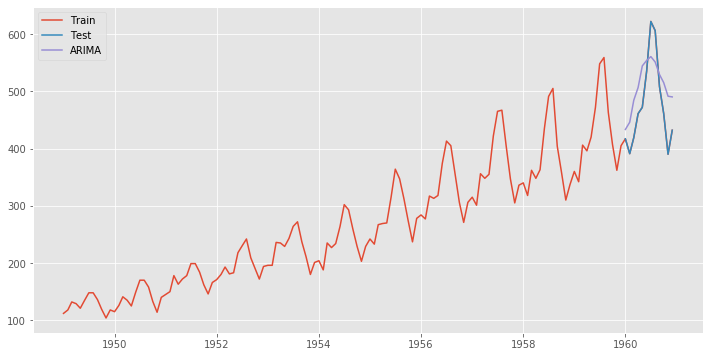

In [31]:
plt.figure(figsize=(12,6))
plt.plot(train['Thousands of Passengers'], label='Train')
plt.plot(test['Thousands of Passengers'], label='Test')
plt.plot(test['Forecasts'], label='ARIMA')
plt.legend()

In [32]:
rmse = np.sqrt(mean_squared_error(test['Thousands of Passengers'],test['Forecasts']))

In [33]:
rmse

57.047034260619135

### 4. 정리  
- ARIMA 모델을 사용하여 multi-step forecasting 하는 방법을 살펴보았다.  
- grid search를 활용한 최적의 파라미터를 찾는 방법을 정리하였다.  

further works  
- rolling forecasts  
- AIC 기반의 하이퍼파라미터 최적화  
- 참고자료  
    - https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/  
    - https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    - https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python